## **Data Preprocessing**

In [1]:
import os
import cv2 as cv
import numpy as np
import shutil as stl
import tensorflow as tf
from PIL import Image

DIM_SIZE = 256 # size of image datapoints; i.e. each image is DIM_SIZExDIM_SIZE in dimensions

# This method generates a directory of the desired format
# for organizing our image data
def gen_dir(dirx):
    os.mkdir(dirx)
    os.mkdir(dirx+'\\'+'desert')
    os.mkdir(dirx+'\\'+'forest')
    os.mkdir(dirx+'\\'+'grassland')
    os.mkdir(dirx+'\\'+'tundra')

# This methods empties the target directory and rebuilds
# the desired directory format
def clean_dir(dirx):
    stl.rmtree(dirx)
    gen_dir(dirx)

# mean of dataset is 871.34375 x 908.65 (height x width); 
# my assumption is we want square images so I recommened 
# we normalize to the average of these dimensions.
def calculate_params(dirx):
    print("Calculating params...",end='',flush=False)
    width_sum = height_sum = size = 0
    for root, dirs, files in os.walk(dirx):
        for filename in files:
            img_path = root + "\\" + filename
            img = cv.imread(img_path)
            dims = img.shape
            height_sum += dims[0]
            width_sum += dims[1]
            size += 1
    width_sum /= size
    height_sum /= size
    print("...params calculated",end='\n',flush=False)
    return [height_sum, width_sum]

# this function is a simple normalization algorithm for 
# our image dataset; changes all file names to required 
# format and adjusts pixel data; also resizes image
# WARNING: path format is optimized for WINDOWS
# it MAY NOT WORK on MAC/LINUX (replace "\\" with "//" to fix this, just my guess lol)
def preprocess_data(dims, dirx, dest):
    for root, dirs, files in os.walk(dirx):
        percent_done = 0
        size_dir = len(files)
        for filename in files:
            print("\rProcessing " + root + "..." + str(int((percent_done/size_dir*100)+0.5)) + "%", end='', flush=True)
            percent_done += 1
            img_path = root + "\\" + filename
            assert os.path.exists(root)
            assert os.path.exists(img_path)
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, dsize=[dims,dims], interpolation=cv.INTER_CUBIC)
            img_array = np.asarray(img)
            buf = filename
            # This section of the algorithm formats the names properly
            i = 0
            if '.jpg' in buf or '.JPG' in buf:
                for char in buf:
                    if char.isnumeric() == False:
                        if char == "N":
                            buf = buf[0:i] + buf[i+1:len(buf)]
                        elif char == "S":
                            buf = "-" + buf[0:i] + buf[i+1:len(buf)]
                            i += 1
                        elif char == "E":
                            buf = buf[0:i] + buf[i+1:len(buf)]
                        elif char == "W":
                            j = buf.find("_")
                            buf = buf[0:j+1] + "-" + buf[j+1:i] + buf[i+1:len(buf)]
                    i += 1
            ext = buf.find(".")
            sub = root.find("\\")
            Image.fromarray(img_array).save(dest + root[sub:len(root)] + "\\" + buf[0:len(buf)-4] + ".jpg")
        if percent_done == size_dir and size_dir > 0:
            print("\n.", end='',flush=False)

# Most lines of the normalize_data step can be skipped after running the above method once - we don't
# need to resize and rename the data each time we make our datasets - the above
# method saves all the formatted images
def main():
    dirx = 'raw_data'
    dest = 'processed_data'
    in_dir = False
    if not os.path.exists(dirx):
        print("Error! Path 'raw_data' does not exist. Path 'raw_data' is required for processing.")
        return 0
    if dest not in os.listdir('.\\'):
        gen_dir(dest)
    for root, dirs, files in os.walk(dest):
        if in_dir:
            if (len(files) > 0) and (len(np.asarray(cv.imread(root+"\\"+files[0]))[0]) == DIM_SIZE):
                print("\rData Already Processed!")
                break
            else:
                clean_dir(dest)
                preprocess_data(DIM_SIZE, dirx, dest)
                print("\rData Processed! Dims: " + str(DIM_SIZE)) # used to be norm_length
                break
        in_dir = True
    
if __name__ == "__main__":
    main()

Data Already Processed!


## **Data Visualization - Pair Plot (and Histogram TBI)** 

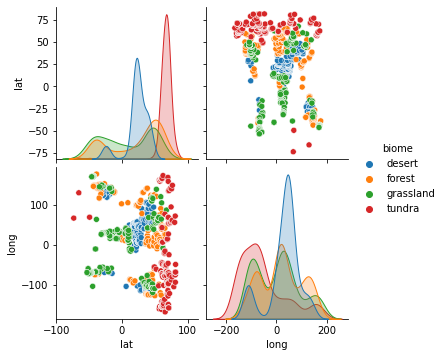

In [2]:
import seaborn as sns
import pandas as pan

# x1 = lat, x2 = long, y = biome
dirx = 'processed_data'
lat_long_df = pan.DataFrame(columns=["lat", "long", "biome"]) 
for root, dirs, files in os.walk(dirx):
    for filename in files:
        split = filename.split('_')
        if len(split) >= 2:
            lat = float(split[0])
            long = float(split[1][0:len(split[1])-4])
            biome = root[root.find('\\')+1:len(root)]
            row = {'lat': lat, 'long': long, 'biome': biome}
            lat_long_df = lat_long_df.append(row, ignore_index = True)
        else:
            print("Failed to parse filename: ", filename)
sns.pairplot(lat_long_df, hue = "biome")

## **Cross Validation Partitioning:**
Each execution of this cell generates **new** validation data. Do **not** execute this cell after training Model 1.<br>
(This code cell **must** be executed before running Model 1)

In [3]:
from sklearn.model_selection import KFold as kfd

NUM_FOLDS_K = 10 # This is the K in K-FoldCV

# Before any of the below code is executed, we need
# directories in which we will dump our partitions:
if 'val_dir' not in os.listdir('.\\'):
    gen_dir('val_dir')
if 'train_dir' not in os.listdir('.\\'):
    gen_dir('train_dir')
if 'test_dir' not in os.listdir('.\\'):
    gen_dir('test_dir')

# This method avoids copy-pasting these same four operations
# repeatedly throughout partitioning the validation data
# and the training data.
def get_dir_lens(dirx):
    d = len(os.listdir(dirx+'\\'+'desert'))
    t = len(os.listdir(dirx+'\\'+'tundra'))
    f = len(os.listdir(dirx+'\\'+'forest'))
    g = len(os.listdir(dirx+'\\'+'grassland'))
    return [d,f,g,t]

# This block of code creates a pandas DataFrame of paths
# to our datapoints for future partitioning in KFold-CV
cols = []
file_frame = pan.DataFrame(columns=['file'])
biome_frame = pan.DataFrame(columns=['biome'])
for root, dirs, files in os.walk('processed_data'):
    biome = ''
    file_list = []
    biome_list = []
    if len(dirs) > 0:
        cols = iter(dirs)
    else:
        biome = next(cols)
    for filename in files:
        file_list.append(root + "\\" + filename)
        biome_list.append(biome)
    if len(file_list) > 0:
        file_frame = file_frame.append(pan.DataFrame(file_list, columns=['file']), ignore_index=True)
        biome_frame = biome_frame.append(pan.DataFrame(biome_list, columns=['biome']), ignore_index=True)
path_frame = file_frame.join(biome_frame).sample(frac=1).reset_index(drop=True) # Dataframe containing paths to all datapoints; WARNING: DO NOT USE, ONLY FOR USE IN THIS CODE CELL
val_data = path_frame.sample(frac=0.1)                                            # Dataframe containing paths to all validation datapoints; WARNING: DO NOT USE, ONLY FOR USE IN THIS CODE CELL

# While the chances of any individual category having no representation
# in the validation partition is negligible, I developed the partitioning with this
# unlikely outcome in mind
clean_dir('val_dir')
print("Partitioning validation data...",end='',flush=False)
for file in val_data['file']:
    subdir = file.find('\\')
    dest = 'val_dir\\' + file[subdir+1:len(file)]
    stl.copy(file, dest)
p = get_dir_lens('vaL_dir')
while p[0] == 0 or p[1] == 0 or p[2] == 0 or p[3] == 0:
    for file in val_data['file']:
        subdir = file.find('\\')
        dest = 'val_dir\\' + file[subdir+1:len(file)]
        stl.copy(file, dest)
    p = get_dir_lens('vaL_dir')
print("...validation data partitioned",end='\n',flush=False)

# Begin KFoldCV:
# cv_train_frames data format: [train_df, test_df]
train_data = path_frame.drop(axis='index',index=val_data.index.values).reset_index(drop=True) # use this guy for later cross-validation
cv_train_frames = []
cross_val = kfd(n_splits=NUM_FOLDS_K)
for i, j in cross_val.split(train_data):
    cv_train_frames.append([pan.concat([train_data.iloc[0:j[0],:], train_data.iloc[(j[len(j)-1]+1):len(train_data),:]]), train_data.iloc[j[0]:(j[len(j)-1]+1),:]])
cv_train_frames[0]

Partitioning validation data......validation data partitioned


[                                            file      biome
 101      processed_data\desert\38.105_86.003.jpg     desert
 102     processed_data\tundra\75.943_-79.371.jpg     tundra
 103    processed_data\desert\36.223_-111.345.jpg     desert
 104    processed_data\tundra\60.765_-152.408.jpg     tundra
 105    processed_data\forest\-11.632_132.729.jpg     forest
 ...                                          ...        ...
 999   processed_data\grassland\10.539_30.873.jpg  grassland
 1000    processed_data\tundra\68.509_-89.827.jpg     tundra
 1001   processed_data\grassland\10.900_5.354.jpg  grassland
 1002    processed_data\tundra\81.251_-67.386.jpg     tundra
 1003   processed_data\desert\-20.249_132.917.jpg     desert
 
 [903 rows x 2 columns],
                                              file      biome
 0         processed_data\tundra\68.953_15.057.jpg     tundra
 1     processed_data\grassland\52.303_138.833.jpg  grassland
 2      processed_data\grassland\10.569_30.443.jpg  gra

## **Model Builder**

In [4]:
from tensorflow.python.client import device_lib
tf.compat.v1.disable_eager_execution()
biome_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=[2,2],padding="same",activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=[2,2],padding="same"),
    tf.keras.layers.Conv2D(filters=32,kernel_size=[2,2],padding="same",activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=[2,2],padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(units=72,activation="relu",activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=36,activation="relu",activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=4,activation="softmax")
])
biome_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.03, momentum=0.3),loss=tf.losses.CategoricalCrossentropy(from_logits=False),metrics=["accuracy"])
print("Model Built!")
print("GPU Available: ")
print(tf.config.list_physical_devices('GPU'))

Model Built!
GPU Available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **Single-Set Model Training Cell**

In [16]:
clean_dir('train_dir')
clean_dir('test_dir')
for file in cv_train_frames[0][0]['file']:
    subdir = file.find('\\')
    dest = 'train_dir\\' + file[subdir+1:len(file)]
    stl.copy(file, dest)
for file in cv_train_frames[0][1]['file']:
    subdir = file.find('\\')
    dest = 'test_dir\\' + file[subdir+1:len(file)]
    stl.copy(file, dest)
norm = tf.keras.layers.Rescaling(1./255)
training_ds = tf.keras.utils.image_dataset_from_directory('train_dir', label_mode="categorical", image_size=(256,256), batch_size=32)
testing_ds = tf.keras.utils.image_dataset_from_directory('test_dir', label_mode="categorical", image_size=(256,256), batch_size=32)
training_ds = training_ds.map(lambda x, y: (norm(x), y))
testing_ds = testing_ds.map(lambda x, y: (norm(x), y))
biome_model.fit(
    training_ds,
    epochs = 60,
    verbose = 0
)
print("Model Trained")

Found 903 files belonging to 4 classes.
Found 101 files belonging to 4 classes.
Model Trained


## **Model with Optimal Parameters CV Average:**

In [6]:
import tensorflow_datasets as tfds
model_accuracy = 0
for k in range(NUM_FOLDS_K):
    biome_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=16,kernel_size=[2,2],padding="same",activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=[2,2],padding="same"),
        tf.keras.layers.Conv2D(filters=32,kernel_size=[2,2],padding="same",activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=[2,2],padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=72,activation="relu",activity_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(units=36,activation="relu",activity_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(units=4,activation="relu")
    ])
    biome_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.03, momentum=0.3),loss=tf.losses.CategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
    clean_dir('train_dir')
    clean_dir('test_dir')
    for file in cv_train_frames[k][0]['file']:
        subdir = file.find('\\')
        dest = 'train_dir\\' + file[subdir+1:len(file)]
        stl.copy(file, dest)
    for file in cv_train_frames[k][1]['file']:
        subdir = file.find('\\')
        dest = 'test_dir\\' + file[subdir+1:len(file)]
        stl.copy(file, dest)
    norm = tf.keras.layers.Rescaling(1./255)
    training_ds = tf.keras.utils.image_dataset_from_directory('train_dir', label_mode="categorical", image_size=(256,256), batch_size=32)
    testing_ds = tf.keras.utils.image_dataset_from_directory('test_dir', label_mode="categorical", image_size=(256,256), batch_size=32)
    training_ds = training_ds.map(lambda x, y: (norm(x), y))
    testing_ds = testing_ds.map(lambda x, y: (norm(x), y))
    biome_model.fit(
        training_ds,
        epochs = 60,
        verbose = 0
    )
    predictions = biome_model.predict(x=testing_ds, verbose = 0)
    labels = []
    dataset = tfds.as_numpy(testing_ds)
    for image, target in dataset:
        for item in target:
            labels.append(item)
    correct = 0
    for x in range(len(predictions)):
        ind_pred = np.argmax(predictions[x])
        ind_val = np.argmax(labels[x])
        if ind_val == ind_pred:
            correct += 1
    model_accuracy += correct/(len(predictions)*NUM_FOLDS_K)
    print("Instantaneous model accuracy: " + str(correct/len(predictions)))
print("General model accuracy: " + str(model_accuracy))

Found 903 files belonging to 4 classes.
Found 101 files belonging to 4 classes.


C:\Users\rstea_nzkrq5m\anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Instantaneous model accuracy: 0.5544554455445545
Found 903 files belonging to 4 classes.
Found 101 files belonging to 4 classes.
Instantaneous model accuracy: 0.7128712871287128
Found 903 files belonging to 4 classes.
Found 101 files belonging to 4 classes.
Instantaneous model accuracy: 0.7029702970297029
Found 903 files belonging to 4 classes.
Found 101 files belonging to 4 classes.
Instantaneous model accuracy: 0.7029702970297029
Found 904 files belonging to 4 classes.
Found 100 files belonging to 4 classes.
Instantaneous model accuracy: 0.74
Found 904 files belonging to 4 classes.
Found 100 files belonging to 4 classes.
Instantaneous model accuracy: 0.69
Found 904 files belonging to 4 classes.
Found 100 files belonging to 4 classes.
Instantaneous model accuracy: 0.68
Found 904 files belonging to 4 classes.
Found 100 files belonging to 4 classes.
Instantaneous model accuracy: 0.74
Found 904 files belonging to 4 classes.
Found 100 files belonging to 4 classes.
Instantaneous model accu

## **Classification Report for Optimal Model**

In [17]:
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report as report
from math import exp
validation_ds = tf.keras.utils.image_dataset_from_directory('val_dir', label_mode="categorical", image_size=(256,256), batch_size=32)
validation_ds = validation_ds.map(lambda x, y: (norm(x), y))
predictions = biome_model.predict(x=validation_ds, verbose = 0)
labels = []
dataset = tfds.as_numpy(validation_ds)
for image, target in dataset:
    for item in target:
        labels.append(item)
correct = 0
for x in range(len(predictions)):
    ind_pred = np.argmax(predictions[x])
    ind_val = np.argmax(labels[x])
    if ind_val == ind_pred:
        correct += 1
#print("Model Accuracy: "+str(correct/len(predictions)))
labels = np.argmax(labels, axis=1)
norm_pred = np.argmax(predictions, axis=1)
stats = report(y_true=labels,y_pred=predictions,target_names=["desert","forest","grassland","tundra"])
print(stats)

Found 112 files belonging to 4 classes.


C:\Users\rstea_nzkrq5m\anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


              precision    recall  f1-score   support

      desert       0.83      0.73      0.78        26
      forest       0.83      0.89      0.86        27
   grassland       0.51      0.81      0.62        31
      tundra       0.91      0.36      0.51        28

    accuracy                           0.70       112
   macro avg       0.77      0.70      0.69       112
weighted avg       0.76      0.70      0.69       112



## **Exporting the Predictions**

In [12]:
norm = tf.keras.layers.Rescaling(1./255)
dummy_ds = tf.keras.utils.image_dataset_from_directory('processed_data', label_mode="categorical", image_size=(256,256), shuffle=False)
dummy_ds = dummy_ds.map(lambda x, y: (norm(x), y))
iter_dummy_ds = tfds.as_numpy(dummy_ds)
target_list = []
raw_predictions = biome_model.predict(dummy_ds)
export_predictions = []
for image, target in iter_dummy_ds:
    for label in target:
        target_list.append(label)
for x in raw_predictions:
    new_item = []
    for y in range(len(x)):
        new_item.append(sigmoid(x[y]))
    export_predictions.append(new_item)
correct = 0
for x in range(len(export_predictions)):
    ind_pred = np.argmax(export_predictions[x])
    ind_val = np.argmax(target_list[x])
    if ind_val == ind_pred:
        correct += 1
print(correct)
export_df = pan.DataFrame(export_predictions, columns=['desert_pred','forest_pred','grassland_pred','tundra_pred']).join(pan.DataFrame(target_list, columns=['desert_label','forest_label','grassland_label','tundra_label']))
export_df.to_csv('cnn_predictions.csv', index=False)

Found 1116 files belonging to 4 classes.
1050


In [9]:
json_file = biome_model.to_json()
with open('.\\saved_models\\model_1.json', 'w') as file:
    file.write(json_file)

In [18]:
biome_model.save('.\\'+'saved_models'+'\\'+'model_1.h5')

In [ ]:
model_load = load_model('./saved_models/model_1.h5')


In [4]:
from math import exp
def sigmoid(x):
    return float(1/(1+exp(-1*x)))

def logit_prediction(pred):
    norm_pred = []
    for i in pred:
        new_item = []
        for j in i:
            j = sigmoid(j)
            new_item.append(j)
        norm_pred.append(new_item)
    norm_pred = np.asarray(norm_pred).reshape((len(pred),4)) # 4 * len(val_data) = 448
    for x in norm_pred:
        index = np.argmax(x)
        for i in range(0, len(x)):
            if i != index:
                x[i] = 0
            else:
                x[i] = 1
    return norm_pred

def get_target_vals(raw_val):
    target_vals = []
    for image, target in raw_val:
        for pred in target:
            target_vals.append(pred)
    target_vals = np.asarray(target_vals).reshape((len(target_vals),4))
    return target_vals

def get_acc(target_vals, norm_pred):
    correct = 0
    assert(len(norm_pred) == len(target_vals))
    for i in range(len(target_vals)):
        index_tv = np.argmax(target_vals[i])
        index_pred = np.argmax(norm_pred[i])
        if index_tv == index_pred:
            correct += 1
    return float(correct/len(target_vals))


In [9]:
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error as mse

TENSOR_SIZE = (DIM_SIZE, DIM_SIZE) # size of tensors for datasets
BATCH_SIZE = 64 # batch of images
TEST_SIZE = 0 # number of validation datapoints len(cv_train_frames[0][1]['file'])

# Validation independent of CV:
norm = tf.keras.layers.Rescaling(1./255)
validation_ds = tf.keras.utils.image_dataset_from_directory('val_dir', label_mode="categorical", image_size=TENSOR_SIZE, batch_size=BATCH_SIZE) #   -  same for all the other datasets
validation_ds = validation_ds.map(lambda x, y: (norm(x), y))


#LOGITS = False
NEURONS_ONE = [24, 48, 72]
NEURONS_TWO = [12, 24, 36]
RATE = [0.01, 0.03, 0.05]
#MOMENT = [0.1, 0.3, 0.5]

# Begin the gridsearch with 10-foldCV
done_count = 0
stats_list = []
for neurons_one in NEURONS_ONE:
    for neurons_two in NEURONS_TWO:
        for rate in RATE:
            model_accuracy = 0
            average_error = 0
            for k in range(NUM_FOLDS_K):
                biome_model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(filters=16,kernel_size=[2,2],padding="same",activation="relu"),
                    tf.keras.layers.MaxPool2D(pool_size=[2,2],padding="same"),
                    tf.keras.layers.Conv2D(filters=32,kernel_size=[2,2],padding="same",activation="relu"),
                    tf.keras.layers.MaxPool2D(pool_size=[2,2],padding="same"),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dropout(rate=0.8),
                    tf.keras.layers.Dense(units=neurons_one,activation="relu",activity_regularizer=tf.keras.regularizers.L2(0.01)),
                    tf.keras.layers.Dense(units=neurons_two,activation="relu",activity_regularizer=tf.keras.regularizers.L2(0.01)),
                    tf.keras.layers.Dense(units=4,activation="relu")
                ])
                biome_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=rate, momentum=0.3),loss=tf.losses.CategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
                clean_dir('train_dir')
                clean_dir('test_dir')
                for file in cv_train_frames[k][0]['file']:
                    subdir = file.find('\\')
                    dest = 'train_dir\\' + file[subdir+1:len(file)]
                    stl.copy(file, dest)
                for file in cv_train_frames[k][1]['file']:
                    subdir = file.find('\\')
                    dest = 'test_dir\\' + file[subdir+1:len(file)]
                    stl.copy(file, dest)
                norm = tf.keras.layers.Rescaling(1./255)
                training_ds = tf.keras.utils.image_dataset_from_directory('train_dir', label_mode="categorical", image_size=(256,256), batch_size=32)
                testing_ds = tf.keras.utils.image_dataset_from_directory('test_dir', label_mode="categorical", image_size=(256,256), batch_size=32)
                training_ds = training_ds.map(lambda x, y: (norm(x), y))
                testing_ds = testing_ds.map(lambda x, y: (norm(x), y))
                biome_model.fit(
                    training_ds,
                    epochs = 60,
                    verbose = 0
                )
                predictions = biome_model.predict(x=testing_ds, verbose = 0)
                norm_pred = []
                labels = []
                dataset = tfds.as_numpy(testing_ds)
                for image, target in dataset:
                    for item in target:
                        labels.append(item)
                for x in predictions:
                    new_item = []
                    for y in range(len(x)):
                        new_item.append(sigmoid(x[y]))
                    norm_pred.append(new_item)
                correct = 0
                for x in range(len(predictions)):
                    ind_pred = np.argmax(norm_pred[x])
                    ind_val = np.argmax(labels[x])
                    if ind_val == ind_pred:
                        correct += 1
                model_accuracy += correct/(len(predictions)*NUM_FOLDS_K)
                average_error += mse(labels, norm_pred)/NUM_FOLDS_K
                print("Instantaneous accuracy: " + str(correct/len(predictions)))
            del biome_model
            stats_list.append([neurons_one, neurons_two, rate, round(model_accuracy,3), round(average_error,3)])
            done_count += 1
            print("Completed "+str(done_count)+" iteration of 27 total iterations " + str(stats_list[done_count-1][3]))
max_index = 0
max_acc = 0
for x in range(len(stats_list)):
    if stats_list[x][3] > max_acc:
        max_index = x
        max_acc = stats_list[x][4]
print("Max index: "+str(max_index))

Found 112 files belonging to 4 classes.


KeyboardInterrupt: 

In [44]:
max_index = 0
max_acc = 0
for x in range(len(stats_list)):
    if stats_list[x][3] > max_acc:
        max_index = x
        max_acc = stats_list[x][3]
print("Max index: "+str(max_index))
print(stats_list[19])

Max index: 19
[72, 12, 0.03, 0.938, 0.025]


The optimal hyperparameters are 72, 36, 0.03. Extra stats: 0.938, and 0.025